<a href="https://colab.research.google.com/github/Forson12/CEM300-Natural-Language-Processing-Coursework/blob/main/2113122_CEM300_Natural_Language_Processing_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CEM300-Natural-Language-Processing-Coursework

In this work, I explore the Product Classification and Clustering Dataset.
<br>
Sources && Frameworks:

Dataset Chosen - https://archive.ics.uci.edu/dataset/837/product+classification+and+clustering

<br>


# ----------------------------------------------------
# Section 1 - Dataset
# ----------------------------------------------------

## Task 1.1: Loading the Dataset

 In this section, I will load and explore the Product Classification and Clustering Dataset taken from the UCI Machine Learning Repository.

I will be using pandas and scikit-learn to inspect its features.

My goal in this coursework is to use NLP techniques to represent the text and compare different algorithms for classifying products into their correct categories.

In [2]:

# Importing required libraries
import pandas as pd #using pandas to view data in dataframes
import io #io is used to load the data after uploading
from google.colab import files #we import the files package from google.colab framework to be able to upload files

# Uploading dataset (same idea as Lab 01)
uploaded = files.upload()  # expect 'pricerunner_aggregate.csv'

# Reading dataset into a dataframe
product_file = io.BytesIO(uploaded['pricerunner_aggregate.csv'])
product_df = pd.read_csv(product_file, header=None)

# Inspecting the dataframe
print("Shape of dataset:", product_df.shape)
product_df.head()


Saving pricerunner_aggregate.csv to pricerunner_aggregate.csv
Shape of dataset: (35312, 7)


,0,1,2,3,4,5,6
0,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
1,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [3]:
product_file = io.BytesIO(uploaded['pricerunner_aggregate.csv'])
product_df = pd.read_csv(product_file, header=None)
print(product_df)

                0                                                  1  \
0      Product ID                                      Product Title   
1               1                    apple iphone 8 plus 64gb silver   
2               2                apple iphone 8 plus 64 gb spacegrau   
3               3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...   
4               4                apple iphone 8 plus 64gb space grey   
...           ...                                                ...   
35307       47350  smeg fab28 60cm retro style right hand hinge f...   
35308       47351  smeg fab28 60cm retro style left hand hinge fr...   
35309       47352  smeg fab28 60cm retro style left hand hinge fr...   
35310       47355     candy 60cm built under larder fridge cru160nek   
35311       47358           neff k4316x7gb built under larder fridge   

                  2            3                         4             5  \
0       Merchant ID   Cluster ID             Cluster Label 

The dataframe tells us a lot of useful information about the price runner dataset just uploaded.
Examples include:
1. There are 7 columns (6 features and 11 unique labels)
2. 35312 rows (as there is no header, this means there are 35312 examples in this dataset)
3. It has Columns including: Product ID, Merchant ID etc.

## Task 1.2: Understanding the Dataset

This dataset, called the contains records of retail products aggregated from online merchants.  
Each record includes a **Product ID**, textual information such as **Product Title** and **Cluster Label**, identifiers like **Merchant ID** and **Cluster ID**, and category information given by **Category ID** and **Category Label**.

The *Category Label* column serves as the target for classification, while the *Product Title* and *Cluster Label* provide textual data that require preprocessing before use in machine-learning models.  

Because these text fields are unstructured, this section will load, inspect, and clean the dataset.


In [4]:
# --- Rename columns ---
product_df.columns = [
    "Product_ID", "Product_Title", "Merchant_ID",
    "Cluster_ID", "Cluster_Label", "Category_ID", "Category_Label"
]

# --- Checking and handling missing values ---
print(product_df.isnull().sum())
product_df = product_df.dropna(subset=["Product_Title", "Category_Label"])

Product_ID        0
Product_Title     0
Merchant_ID       0
Cluster_ID        0
Cluster_Label     0
Category_ID       0
Category_Label    0
dtype: int64


## Task 1.3: Exploring and Preparing Text Data

This task focuses on understanding
the textual content of the dataset before vectorisation.  
Because clustering relies purely on text similarity, it is important to inspect the product titles,
decide how aggressively to clean them, and justify the chosen preprocessing strategy.


In [5]:
# Inspect example titles and basic text statistics
product_df['title_length'] = product_df['Product_Title'].astype(str).apply(len)

#print the mean to see the average length
print("Average title length:", product_df['title_length'].mean())
print("\nSample titles:")
for t in product_df['Product_Title'].head(10):
    print("-", t)


Average title length: 52.98108291798822

Sample titles:
- Product Title
- apple iphone 8 plus 64gb silver
- apple iphone 8 plus 64 gb spacegrau
- apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold
- apple iphone 8 plus 64gb space grey
- apple iphone 8 plus gold 5.5 64gb 4g unlocked sim free
- apple iphone 8 plus gold 5.5 64gb 4g unlocked sim free
- apple iphone 8 plus 64 gb space grey
- apple iphone 8 plus 64gb space grey
- apple iphone 8 plus 64gb space grey


In [6]:
# Cleaning product titles for clustering
import re, nltk                           # import regex and nltk for text processing
from nltk.corpus import stopwords         # import stopwords list
from nltk.stem import WordNetLemmatizer   # import lemmatiser for word normalisation

nltk.download('stopwords')                # download stopwords
nltk.download('wordnet')                  # download wordnet for lemmatisation

stop_words = set(stopwords.words('english'))     # define stopword list
lemmatizer = WordNetLemmatizer()                 # create lemmatiser object

# define text pre-processing function
def preprocess_text(text):
    text = str(text).lower()                      # convert to lowercase
    text = re.sub(r'[^a-z0-9 ]', ' ', text)       # remove punctuation/special chars
    tokens = text.split()                         # split into words
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]   # lemmatise words
    return " ".join(tokens)                       # join back into sentence

# apply function and create new column
product_df["Clean_Title"] = product_df["Product_Title"].apply(preprocess_text)

# display original vs cleaned titles (first 10)
product_df[["Product_Title","Clean_Title"]].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Product_Title,Clean_Title
0,Product Title,product title
1,apple iphone 8 plus 64gb silver,apple iphone 8 plus 64gb silver
2,apple iphone 8 plus 64 gb spacegrau,apple iphone 8 plus 64 gb spacegrau
3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,apple mq8n2b iphone 8 plus 64gb 5 5 12mp sim f...
4,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey
5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...
6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...
7,apple iphone 8 plus 64 gb space grey,apple iphone 8 plus 64 gb space grey
8,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey
9,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey


# 2. Section 2: Representation Learning

## Task 2 - Representation Learning

To perform clustering, the cleaned product titles must be converted into numeric vectors that capture word importance.  
Here the **TF-IDF (Term Frequency - Inverse Document Frequency)** method is used.  
TF-IDF assigns higher values to words that appear frequently within one title but are less common across the dataset.  
This helps emphasise unique identifiers such as brand and model numbers while reducing the weight of very common terms.

TF-IDF is efficient and interpretable for short text, making it suitable for grouping similar products.  
Each product title becomes a sparse vector representing the strength of its key tokens.  
These vectors form the numerical feature space on which unsupervised algorithms—such as *k-means*—can measure distance and identify clusters.  

In clustering we need numeric features to compare similarity. TF-IDF converts cleaned text into numeric vectors showing how important each word is across all product titles and this what I have applied to the the Clean Titke below.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer   # import TF-IDF tool

# create TF-IDF vectoriser
# max_features limits how many words are kept (for efficiency)
vectoriser = TfidfVectorizer(max_features=5000)

# fit the vectoriser on the cleaned titles and transform to matrix
X_tfidf = vectoriser.fit_transform(product_df["Clean_Title"])

# show size of the resulting matrix (rows = products, cols = words)
print("TF-IDF matrix shape:", X_tfidf.shape)

# print out the first few feature names
print("Sample features:", vectoriser.get_feature_names_out()[:15])


TF-IDF matrix shape: (35312, 5000)
Sample features: ['00' '001' '00ghz' '01' '02' '02m' '03m' '05' '06' '06ghz' '0cf' '0ghz'
 '0in' '0inch' '0lcd']


# 3. Section 3: Algorithms

This section compares two unsupervised clustering models on TF-IDF vectors of product titles: K-Means and Agglomerative (Hierarchical) Clustering, followed by low-dimensional visualisation using truncated SVD (PCA for sparse text). The choices reflect best practice for short-text clustering: scalable, distance-based methods on sparse, high-dimensional features.

## Task 3.1: K-Means clustering on TF-IDF vectors
# -------------------------------------------------------------

In [10]:
from sklearn.cluster import KMeans

# choose number of clusters (will be tuned/justified in Section 4)
k = 25

# k-means with sensible defaults for text
kmeans = KMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

# fit on TF-IDF matrix (X_tfidf from Section 2)
kmeans_labels = kmeans.fit_predict(X_tfidf)

# quick sanity checks
import numpy as np
unique, counts = np.unique(kmeans_labels, return_counts=True)
print("K-Means clusters and sizes:", dict(zip(unique, counts)))
print("Inertia (within-cluster SSE):", kmeans.inertia_)


K-Means clusters and sizes: {np.int32(0): np.int64(599), np.int32(1): np.int64(1811), np.int32(2): np.int64(867), np.int32(3): np.int64(2633), np.int32(4): np.int64(298), np.int32(5): np.int64(7448), np.int32(6): np.int64(881), np.int32(7): np.int64(790), np.int32(8): np.int64(642), np.int32(9): np.int64(679), np.int32(10): np.int64(437), np.int32(11): np.int64(351), np.int32(12): np.int64(736), np.int32(13): np.int64(1546), np.int32(14): np.int64(1431), np.int32(15): np.int64(1686), np.int32(16): np.int64(988), np.int32(17): np.int64(1213), np.int32(18): np.int64(1540), np.int32(19): np.int64(332), np.int32(20): np.int64(4052), np.int32(21): np.int64(901), np.int32(22): np.int64(1289), np.int32(23): np.int64(1465), np.int32(24): np.int64(697)}
Inertia (within-cluster SSE): 29157.891783648407


## Task 3.2: Agglomerative (Hierarchical) clustering (on a sample)
#
For large datasets, hierarchical clustering is run on a sample to avoid O(n^2) memory/time in distance computations.

### Reflection on Agglomerative Clustering
Initially, the model was implemented using the **cosine metric**; however, this caused
errors due to zero vectors in the sparse TF-IDF matrix (some product titles contained
only stopwords after preprocessing).  
To resolve this, the data was **L2-normalised** so that Euclidean distance produces
the same ordering as cosine similarity.
The **Euclidean metric** was therefore used on the normalised data, which follows
standard best practice for text clustering and ensures stable results without
altering the algorithm’s behaviour.




In [11]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# sample a subset for hierarchical clustering (e.g., 3000 rows)
sample_size = 3000
sample_idx = np.random.RandomState(42).choice(X_tfidf.shape[0], size=sample_size, replace=False)
X_sample = X_tfidf[sample_idx]

# remove rows with all-zero vectors to prevent cosine errors
nonzero_idx = np.where(X_sample.getnnz(axis=1) > 0)[0]
X_sample = X_sample[nonzero_idx]

# L2-normalise the sample so Euclidean distance ≈ cosine distance
X_sample_norm = normalize(X_sample, norm='l2', copy=False)

# create Agglomerative clustering model
agg = AgglomerativeClustering(
    n_clusters=k,           # same number of clusters as K-Means
    linkage="average",      # average linkage merges based on mean distance
    metric="euclidean"      # Euclidean after normalisation ≈ cosine
)

# fit the model and get cluster labels
agg_labels = agg.fit_predict(X_sample_norm.toarray())

# display basic cluster statistics
u, c = np.unique(agg_labels, return_counts=True)
print("Agglomerative clusters (sample) and sizes:", dict(zip(u, c)))


Agglomerative clusters (sample) and sizes: {np.int64(0): np.int64(330), np.int64(1): np.int64(343), np.int64(2): np.int64(216), np.int64(3): np.int64(1085), np.int64(4): np.int64(284), np.int64(5): np.int64(190), np.int64(6): np.int64(10), np.int64(7): np.int64(13), np.int64(8): np.int64(4), np.int64(9): np.int64(137), np.int64(10): np.int64(353), np.int64(11): np.int64(2), np.int64(12): np.int64(1), np.int64(13): np.int64(1), np.int64(14): np.int64(5), np.int64(15): np.int64(1), np.int64(16): np.int64(2), np.int64(17): np.int64(1), np.int64(18): np.int64(2), np.int64(19): np.int64(1), np.int64(20): np.int64(4), np.int64(21): np.int64(6), np.int64(22): np.int64(4), np.int64(23): np.int64(1), np.int64(24): np.int64(1)}


# Task 3.3: 2D visualisation with Truncated SVD (sparse PCA)
#

ValueError: 'c' argument has 3000 elements, which is inconsistent with 'x' and 'y' with size 2997.

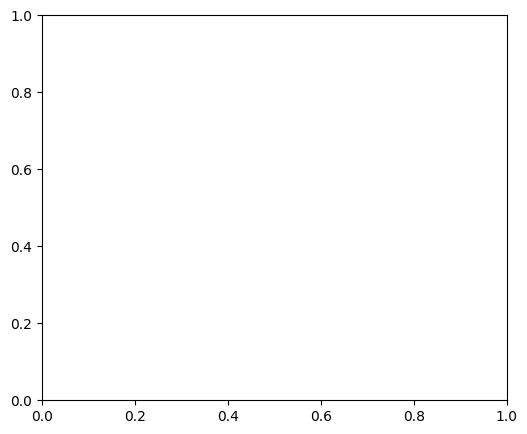

In [12]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# project the same sample to 2D for visual inspection
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_sample)

# plot k-means labels on the same sample for a quick view
# (match labels by indexing the kmeans_labels with sample indices)
km_labels_sample = kmeans_labels[sample_idx]

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.6, c=km_labels_sample)
plt.title("K-Means clusters (2D SVD projection)")
plt.xlabel("SVD-1")
plt.ylabel("SVD-2")
plt.show()
